In [1]:
# necessary libraries
using Plots
using ForwardDiff
using Printf
using LinearAlgebra
#using statistics

# Test functions

In [2]:
# a simple qudratic function
f2(x) = [x[1]^2 + x[1]*x[2] + x[2]^2]
f2_plot(x, y) = x^2 + x*y + y^2
∇f2(x) = ForwardDiff.jacobian(f2, x)[1,:]

# Rosen***
f_b(x; a=1, b=5) = (a - x[1])^2 + b*(x[2] - x[1]^2)^2
∇f_b(x) = [20x[1]^3 + (2 - 20x[2])x[1] - 2, 10(x[2] - x[1]^2)]

∇f_b (generic function with 1 method)

In [3]:
function rosenplot(ticks=false)
    f_banana(x, y; a=1., b=5.) = (a-x)^2 + b*(y - x^2)^2
    x, y = -2:0.01:2, -2:0.01:2
    contour(x, y, f_banana,
        size=(400, 400),
        framestyle=:box,
        #color=cgrad(:viridis, rev=true),
        levels=collect(2 .^(0:7)),
        #legend=false,
        xlims=(-2, 2),
        ylims=(-2, 2),
        grid=false,
        ticks=ticks,
        xlabel="x_1",
        ylabel="x_2")
end

rosenplot (generic function with 2 methods)

# Line search

In [4]:
function line_search(f, ∇, x, d; α=5, β=1e-4, σ=0.1, max_iter=20) 
    y0, g0, y_prev, α_prev = f(x)[1], ∇(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    # bracket phase
    while true
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev) 
            αlo, αhi = α_prev, α
            break 
        end
                
        g = ∇(x + α*d)⋅d 
        if abs(g) ≤ -σ*g0
            return α 
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break 
        end
        y_prev, α_prev, α = y, α, 2α 
    end
    
    # zoom phase
    ylo = f(x + αlo*d)[1]
    n = 0
    while n < max_iter
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y ≥ ylo #
            αhi = α 
        else
            g = ∇(x + α*d)⋅d 
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo 
            end
            αlo = α 
        end
        n += 1
    end
    #return #return something if it fails to find the suitable alpha
end



line_search (generic function with 1 method)

# Steepest Descent

In [5]:
abstract type DescentMethod end

In [6]:
mutable struct GradientDescent <: DescentMethod
    x
    α
end

In [7]:
function step!(M::GradientDescent, f, ∇f, linesearch=false)
    g = -∇f(M.x) 
    d = g/norm(g) #normalize the gradient or not
    if linesearch #variable alpha
        M.α = line_search(f, ∇f, M.x, d)
    end
    M.x += M.α*d
end

step! (generic function with 2 methods)

In [8]:
function optimize(M::GradientDescent, f, ∇f, line_search=true, f_tol=1e-10, g_tol=1e-2, max_iter=1000)
    
    xs = rand(1, length(M.x))
    for (i, m) in enumerate(M.x)
        xs[1,i] = m
    end
    
    for i in 1:max_iter
        x_prev = M.x
        step!(M::GradientDescent, f, ∇f, line_search)
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 5 methods)

In [9]:
x0 = [3.0, 0]

M1 = GradientDescent(x0, 0.5)
xs_fixed = optimize(M1, f2, ∇f2, false)

M2 = GradientDescent(x0, 0.1)
xs_linesearch = optimize(M2, f2, ∇f2, true);

Terminate due to gradient tolerance


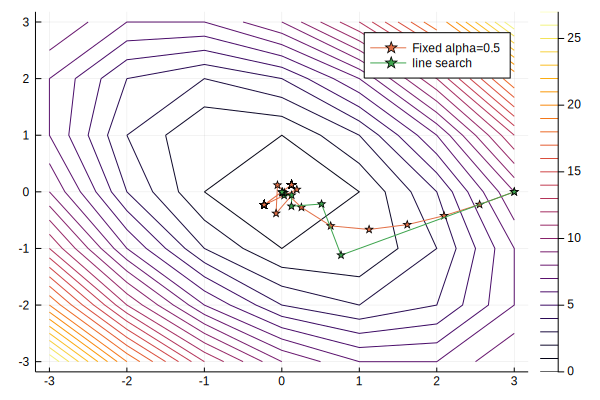

In [10]:
x = -3:1:3.5
y = -3:1:3.5
contour(x, y, f2_plot; levels = collect(0:1:30))
plot!([xs_fixed[:,1]], [xs_fixed[:,2]], m=:s, label=string("Fixed alpha=", M1.α))
plot!([xs_linesearch[:,1]], [xs_linesearch[:,2]], m=:s, label="line search")

# Conjugate Gradient 

In [11]:
#abstract type DescentMethod end

mutable struct ConjugateGradientDescent <: DescentMethod
    x 
    α
    d #direction
    g
end

In [12]:
function step!(M::ConjugateGradientDescent, f, ∇f, linesearch)
    d, g = M.d, M.g
    g′ = ∇f(M.x)
    β = max(0, dot(g′, g′-g)/(g⋅g)) 
    d′ = -g′ + β*d
    if linesearch #variable alpha
        M.α = line_search(f, ∇f, M.x, d′)
    end
    M.x += M.α*d′
    M.d, M.g = d′, g′
end

step! (generic function with 3 methods)

In [13]:
function optimize(M::ConjugateGradientDescent, f, ∇f, line_search=true, f_tol=1e-10, g_tol=1e-2, max_iter=1000)

    xs = rand(1, length(M.x))
    for (i, m) in enumerate(M.x)
        xs[1,i] = m
    end
    for i in 1:max_iter
        x_prev = M.x
        step!(M::ConjugateGradientDescent, f, ∇f, line_search)
        xs = [xs; (M.x)']
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end


optimize (generic function with 10 methods)

In [14]:
x0 = [3, 0]

M1 = ConjugateGradientDescent(x0, 0.5, -∇f2(x0), ∇f2(x0))
xs_CG_fixed = optimize(M1, f2, ∇f2, false)

M2 = ConjugateGradientDescent(x0, 0.1, -∇f2(x0), ∇f2(x0))
xs_CG_linesearch = optimize(M2, f2, ∇f2, true);

Terminate due to gradient tolerance
Terminate due to gradient tolerance


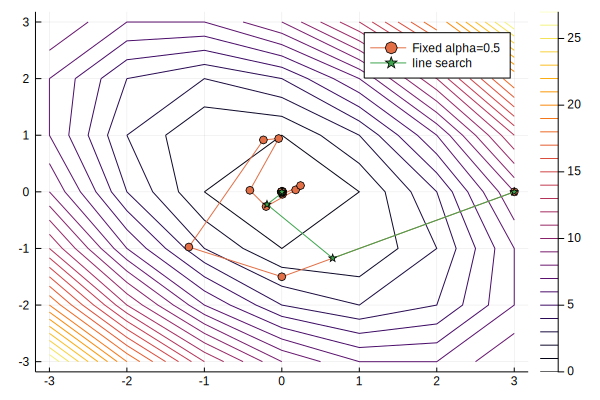

In [15]:
x = -3:1:3.5
y = -3:1:3.5
contour(x, y, f2_plot; levels = collect(0:1:30))
plot!([xs_CG_fixed[:,1]], [xs_CG_fixed[:,2]], m=:o, label=string("Fixed alpha=", M1.α))
plot!([xs_CG_linesearch[:,1]], [xs_CG_linesearch[:,2]], m=:s, label="line search")

# Comparison between CG and SD

Terminate due to gradient tolerance
Terminate due to gradient tolerance


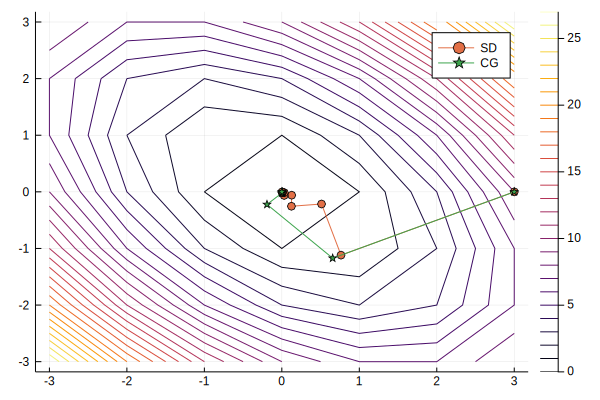

In [16]:
x0 = [3, 0]

M1 = GradientDescent(x0, 0.5)
xs_SD = optimize(M1, f2, ∇f2, true)

M2 = ConjugateGradientDescent(x0, 0.1, -∇f2(x0), ∇f2(x0))
xs_CG = optimize(M2, f2, ∇f2, true);

x = -3:1:3.5
y = -3:1:3.5
contour(x, y, f2_plot; levels = collect(0:1:30))
plot!([xs_SD[:,1]], [xs_SD[:,2]], m=:o, label="SD")
plot!([xs_CG[:,1]], [xs_CG[:,2]], m=:s, label="CG")

Terminate due to gradient tolerance
Terminate due to gradient tolerance


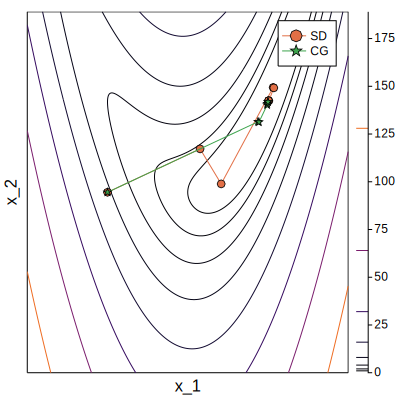

In [17]:
x0 = [-1, 0]

M1 = GradientDescent(x0, 0.5)
xs_SD = optimize(M1, f_b, ∇f_b, true)

M2 = ConjugateGradientDescent(x0, 0.1, -∇f_b(x0), ∇f_b(x0))
xs_CG = optimize(M2, f_b, ∇f_b, true);

rosenplot()
plot!([xs_SD[:,1]], [xs_SD[:,2]], m=:o, label="SD")
plot!([xs_CG[:,1]], [xs_CG[:,2]], m=:s, label="CG")